# Lab 5: LHC Particle Physics Data Analysis

**Author:** Tianyu

**Course:** Physics 434 - Data Analysis Lab  
**Objective:** Explore LHC particle physics data and optimize discovery significance through event selection

In this lab, you will work with realistic particle physics data from the Large Hadron Collider (LHC). The goal is to identify Higgs boson signals from QCD background noise using jet substructure analysis and cut-based optimization.

## Dataset Information

Two pT (transverse momentum) ranges are provided:

### Low pT (250-500 GeV/c): `Sample_pt_250_500`
- **Training samples:**
  - `higgs_100000_pt_250_500.pkl` (Expected yields: N_higgs = 100)
  - `qcd_100000_pt_250_500.pkl` (Expected yields: N_qcd = 20,000)
- **Pseudo-experiments:**
  - `data_highLumi_pt_250_500.h5`
  - `data_lowLumi_pt_250_500.h5`

### High pT (1000-1200 GeV/c): `Sample_pt_1000_1200`
- **Training samples:**
  - `higgs_100000_pt_1000_1200.pkl` (Expected yields: N_higgs = 50)
  - `qcd_100000_pt_1000_1200.pkl` (Expected yields: N_qcd = 2,000)
- **Pseudo-experiments:**
  - `data_highLumi_pt_1000_1200.h5`
  - `data_lowLumi_pt_1000_1200.h5`

## Physics Background

### What is a Jet?
A jet is a collection of particles traveling in the same direction, originating from a hard quark or gluon through bremsstrahlung and fragmentation processes.

### Jet Substructure
At high transverse momenta, heavy particles (W, Z, Higgs, top quarks) have collimated decays. Standard jet identification fails because all decay products end up in a single jet. **Jet substructure variables** computed from constituent 4-momenta help distinguish boosted heavy particles with two-pronged decays from QCD jets.

### Key Variables:
- **mass**: Jet invariant mass (GeV)
- **d2**: Jet substructure variable for two-pronged discrimination
- **η (eta)**: Pseudorapidity (geometric quantity related to polar angle)
- **φ (phi)**: Azimuthal angle around the beam

**Extended Reading:**
- ATLAS detector: https://arxiv.org/pdf/1709.04533.pdf
- Jet substructure: https://arxiv.org/abs/1201.0008

## Setup and Data Loading

In [224]:
# TODO: Import required libraries
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [225]:
# TODO: Load the QCD background data
# Use pickle to load: Sample_pt_250_500/qcd_100000_pt_250_500.pkl
with open("/content/sample_data/Sample_pt_250_500/qcd_100000_pt_250_500.pkl", "rb") as f:
    qcd_data = pickle.load(f)

In [226]:
# TODO: Load the Higgs signal data
# Use pickle to load: Sample_pt_250_500/higgs_100000_pt_250_500.pkl
with open("/content/sample_data/Sample_pt_250_500/higgs_100000_pt_250_500.pkl", "rb") as f:
    higgs_data = pickle.load(f)


In [227]:
# TODO: Explore the data structure
# Print the keys available in the data dictionary
# Print the first few values of 'mass' and 'd2'
print(qcd_data.keys())
print(qcd_data['mass'][:5])
print(qcd_data['d2'][:5])

Index(['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1',
       't2', 't3', 't21', 't32', 'KtDeltaR'],
      dtype='object')
0    125.298720
1     88.047054
2     85.794174
3     42.947328
4     59.542227
Name: mass, dtype: float64
0    3.304886
1    2.439089
2    4.118371
3    8.038338
4    6.353842
Name: d2, dtype: float64


# Task 1: Visualization (3 points)

Explore the low pT dataset (`Sample_pt_250_500`). Make representative plots of each feature to understand the data structure and characteristics.

## Part (a): Individual Feature Distributions

Create histograms for each available feature in both signal and background datasets.

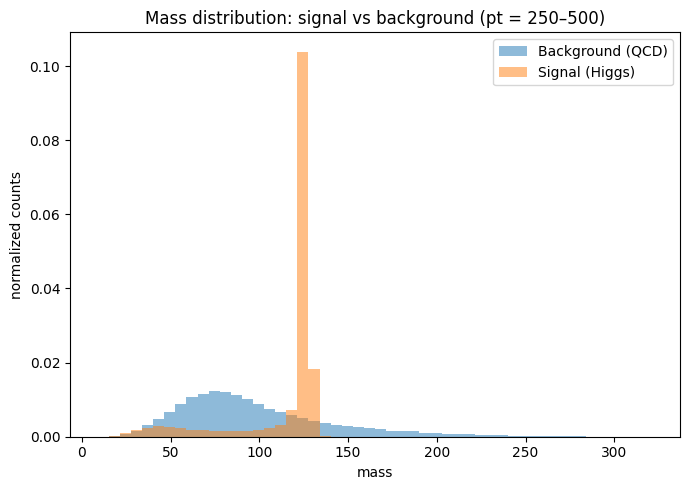

In [228]:
col = "mass"
if col not in higgs_data or col not in qcd_data:
    raise KeyError(f"Column '{col}' must exist in both signal and background DataFrames.")

plt.figure(figsize=(7,5))
combined = pd.concat([higgs_data[col], qcd_data[col]], ignore_index=True)
bins = np.histogram_bin_edges(combined.dropna(), bins=50)

plt.hist(qcd_data[col].dropna(),   bins=bins, density=True, alpha=0.5, label="Background (QCD)")
plt.hist(higgs_data[col].dropna(), bins=bins, density=True, alpha=0.5, label="Signal (Higgs)")

plt.xlabel("mass")
plt.ylabel("normalized counts")
plt.title("Mass distribution: signal vs background (pt = 250–500)")
plt.legend()
plt.tight_layout()
plt.show()

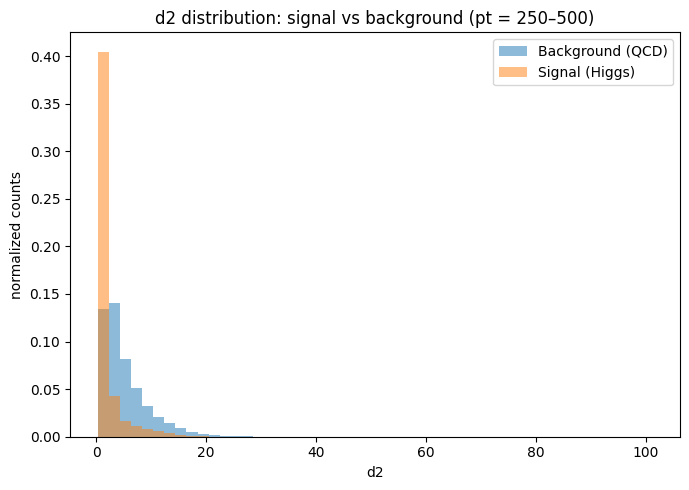

In [229]:
# TODO: Plot d2 distributions for signal and background

col = "d2"
if col not in higgs_data or col not in qcd_data:
    raise KeyError(f"Column '{col}' must exist in both signal and background DataFrames.")

plt.figure(figsize=(7,5))

combined = pd.concat([higgs_data[col], qcd_data[col]], ignore_index=True)
bins = np.histogram_bin_edges(combined.dropna(), bins=50)

plt.hist(qcd_data[col].dropna(),   bins=bins, density=True, alpha=0.5, label="Background (QCD)")
plt.hist(higgs_data[col].dropna(), bins=bins, density=True, alpha=0.5, label="Signal (Higgs)")

plt.xlabel("d2")
plt.ylabel("normalized counts")
plt.title("d2 distribution: signal vs background (pt = 250–500)")
plt.legend()
plt.tight_layout()
plt.show()

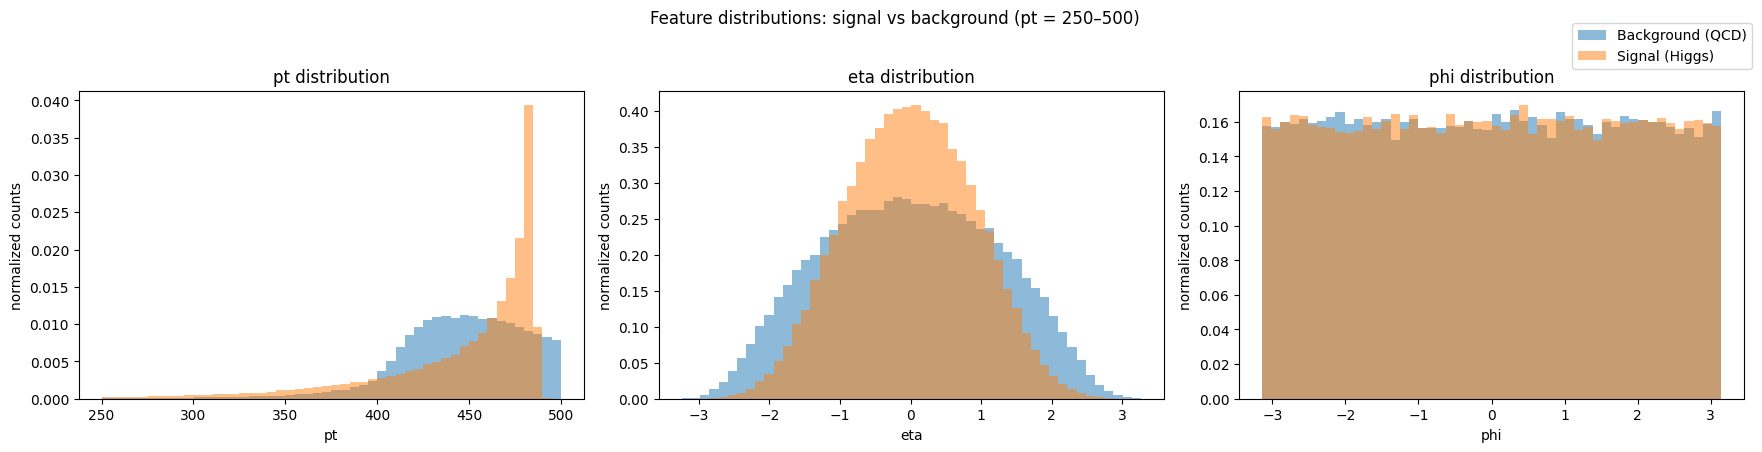

In [230]:
# TODO: Plot other available features (pt, eta, phi, etc.)
# Create a multi-panel figure showing all features



candidate_feats = ["pt", "eta", "phi"]
features = [c for c in candidate_feats if (c in higgs_data.columns and c in qcd_data.columns)]
if not features:
    raise ValueError("No overlapping features found from the candidate list. Add valid column names to 'candidate_feats'.")

n = len(features)
ncols = 3
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 4.5*nrows), squeeze=False)

for idx, feat in enumerate(features):
    r, c = divmod(idx, ncols)
    ax = axes[r][c]

    combined = pd.concat([higgs_data[feat], qcd_data[feat]], ignore_index=True).dropna()
    combined = combined[np.isfinite(combined)]
    if combined.empty:
        ax.text(0.5, 0.5, f"No valid data for {feat}", ha="center", va="center")
        ax.axis("off")
        continue
    bins = np.histogram_bin_edges(combined, bins=50)

    ax.hist(qcd_data[feat].dropna(),   bins=bins, density=True, alpha=0.5, label="Background (QCD)")
    ax.hist(higgs_data[feat].dropna(), bins=bins, density=True, alpha=0.5, label="Signal (Higgs)")
    ax.set_xlabel(feat)
    ax.set_ylabel("normalized counts")
    ax.set_title(f"{feat} distribution")


for j in range(n, nrows*ncols):
    r, c = divmod(j, ncols)
    axes[r][c].axis("off")
handles, labels = axes[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(0.98, 0.98))
fig.suptitle("Feature distributions: signal vs background (pt = 250–500)", y=0.995)
plt.tight_layout(rect=[0, 0, 0.98, 0.97])
plt.show()


## Part (b): Summary Statistics

Calculate and display basic statistics for key features.

In [231]:
# TODO: Calculate mean, std, min, max for mass and d2
# === SUMMARY STATISTICS FOR KEY FEATURES ===
features = ["mass", "d2"]
summary = {}

for feat in features:
    if feat not in higgs_data.columns or feat not in qcd_data.columns:
        print(f"Warning: {feat} not found in both datasets, skipping.")
        continue

    summary[feat] = {
        "Higgs_mean": higgs_data[feat].mean(),
        "Higgs_std":  higgs_data[feat].std(),
        "Higgs_min":  higgs_data[feat].min(),
        "Higgs_max":  higgs_data[feat].max(),
        "QCD_mean":   qcd_data[feat].mean(),
        "QCD_std":    qcd_data[feat].std(),
        "QCD_min":    qcd_data[feat].min(),
        "QCD_max":    qcd_data[feat].max(),
    }

summary_df = pd.DataFrame(summary).T
print("=== Summary Statistics for Key Features (mass, d2) ===")
print(summary_df.round(4))

=== Summary Statistics for Key Features (mass, d2) ===
      Higgs_mean  Higgs_std  Higgs_min  Higgs_max  QCD_mean  QCD_std  QCD_min  \
mass    114.8924    25.3511     8.9712   142.4396   97.7380  43.4929   9.2928   
d2        1.9667     2.5006     0.2751    33.7228    5.2094   4.2852   0.2813   

       QCD_max  
mass  321.3980  
d2    101.1566  


# Task 2: Data Exploration (3 points)

Study correlations between mass and d2 jet substructure variable to build a cut-based analysis.

## Part (a): Distribution Comparison and 2D Scatter Plots

Create mass and d2 distributions, and 2D scatter plots for signal (```'Higgs Signal'```) and background (```'QCD Background'```).

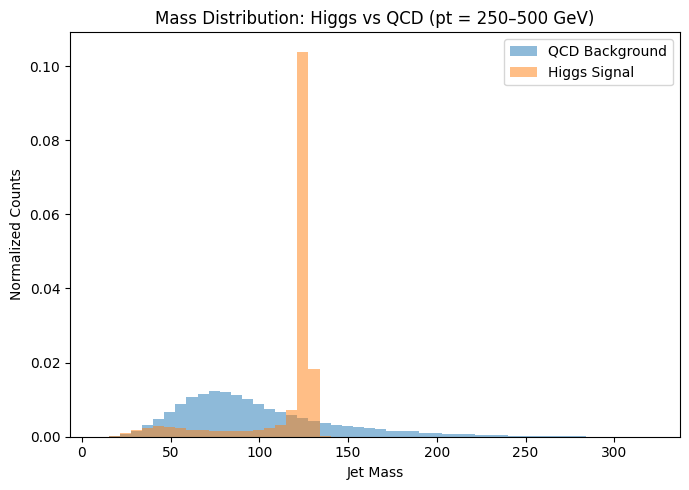

In [232]:
# TODO: Create two plots showing mass distributions (signal vs background)
# Describe the shape and discrimination power
if "mass" not in higgs_data.columns or "mass" not in qcd_data.columns:
    raise KeyError("Column 'mass' not found in both datasets.")

plt.figure(figsize=(7,5))

combined = pd.concat([higgs_data["mass"], qcd_data["mass"]], ignore_index=True)
bins = np.histogram_bin_edges(combined.dropna(), bins=50)

plt.hist(qcd_data["mass"].dropna(),   bins=bins, density=True, alpha=0.5, label="QCD Background")
plt.hist(higgs_data["mass"].dropna(), bins=bins, density=True, alpha=0.5, label="Higgs Signal")

plt.xlabel("Jet Mass")
plt.ylabel("Normalized Counts")
plt.title("Mass Distribution: Higgs vs QCD (pt = 250–500 GeV)")
plt.legend()
plt.tight_layout()
plt.show()

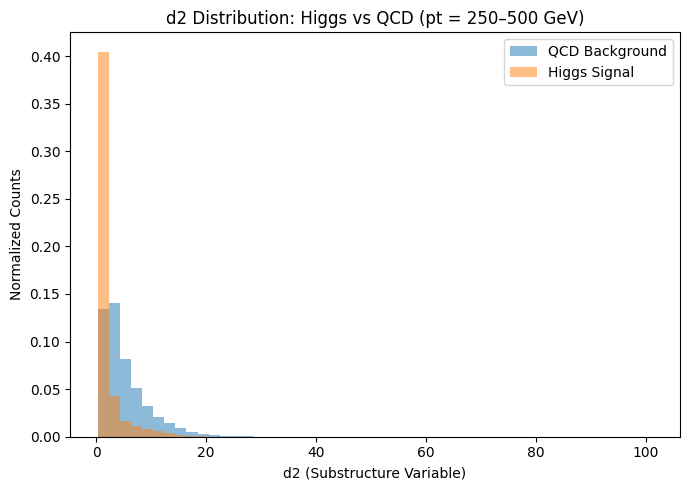

In [233]:
# TODO: Create two plots showing d2 distributions (signal vs background)
# Describe the shape and discrimination power

if "d2" not in higgs_data.columns or "d2" not in qcd_data.columns:
    raise KeyError("Column 'd2' not found in both datasets.")

plt.figure(figsize=(7,5))

combined = pd.concat([higgs_data["d2"], qcd_data["d2"]], ignore_index=True)
bins = np.histogram_bin_edges(combined.dropna(), bins=50)

plt.hist(qcd_data["d2"].dropna(),   bins=bins, density=True, alpha=0.5, label="QCD Background")
plt.hist(higgs_data["d2"].dropna(), bins=bins, density=True, alpha=0.5, label="Higgs Signal")

plt.xlabel("d2 (Substructure Variable)")
plt.ylabel("Normalized Counts")
plt.title("d2 Distribution: Higgs vs QCD (pt = 250–500 GeV)")
plt.legend()
plt.tight_layout()
plt.show()


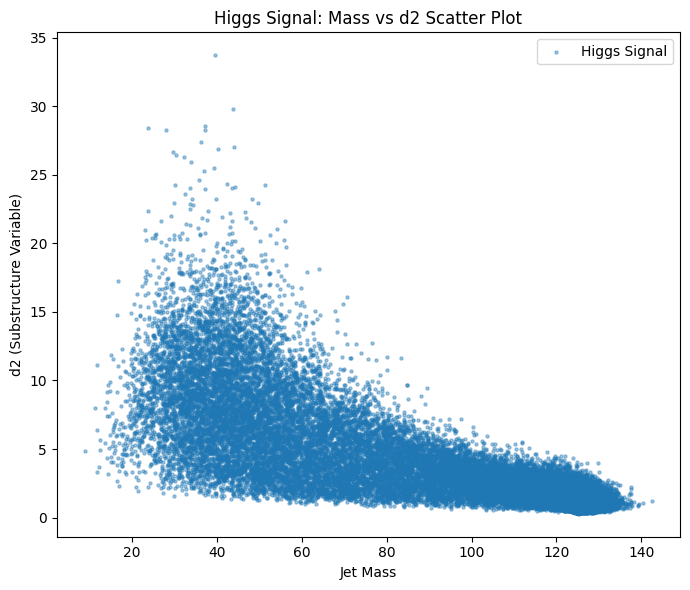

In [234]:
# TODO: Create 2D scatter plot of mass vs d2 for signal
plt.figure(figsize=(7,6))
plt.scatter(higgs_data["mass"], higgs_data["d2"],
            s=5, alpha=0.4, c="tab:blue", label="Higgs Signal")

plt.xlabel("Jet Mass")
plt.ylabel("d2 (Substructure Variable)")
plt.title("Higgs Signal: Mass vs d2 Scatter Plot")
plt.legend()
plt.tight_layout()
plt.show()

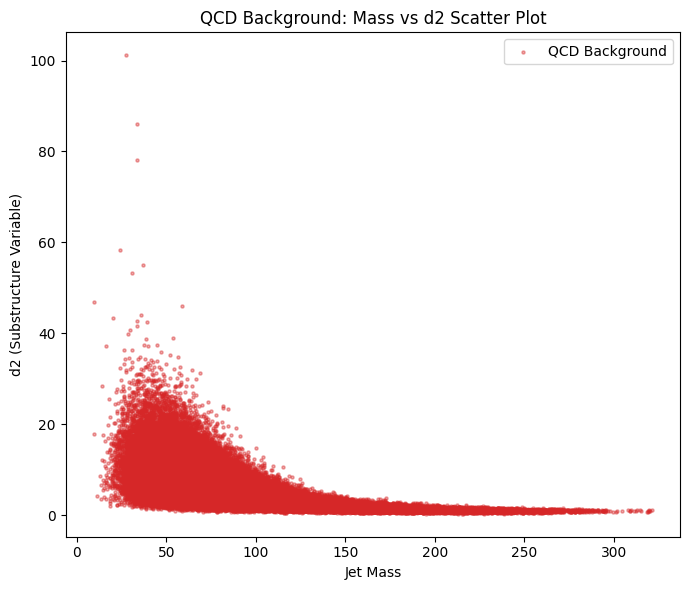

In [235]:
# TODO: Create 2D scatter plot of mass vs d2 for background
# === Step 4: 2D scatter plot for QCD background ===
plt.figure(figsize=(7,6))
plt.scatter(qcd_data["mass"], qcd_data["d2"],
            s=5, alpha=0.4, c="tab:red", label="QCD Background")

plt.xlabel("Jet Mass")
plt.ylabel("d2 (Substructure Variable)")
plt.title("QCD Background: Mass vs d2 Scatter Plot")
plt.legend()
plt.tight_layout()
plt.show()

**Question:** Describe the discrimination power of mass and d2 for separating signal from background.

**Your Answer:**
The **mass** variable shows strong separation because the Higgs signal peaks around a specific value, while the QCD background is broad and flat.
The **d2** variable also helps since Higgs jets have smaller d2 values, showing a clear two-prong structure, while QCD jets have larger and more spread-out d2 values.
Together, using both variables can clearly distinguish signal from background.


## Part (b): Weighted Distributions

Re-weight signal (N_signal = 100) and background (N_background = 20,000) to match expected yields.

In [236]:
# TODO: Calculate weights for signal and background
# N_signal_expected = 100, N_background_expected = 20000
N_signal_expected = 100
N_background_expected = 20000
N_signal_actual = len(higgs_data)
N_background_actual = len(qcd_data)
w_signal = N_signal_expected / N_signal_actual
w_background = N_background_expected / N_background_actual

print(f"Signal weight: {w_signal:.5f}")
print(f"Background weight: {w_background:.5f}")

Signal weight: 0.00100
Background weight: 0.20000


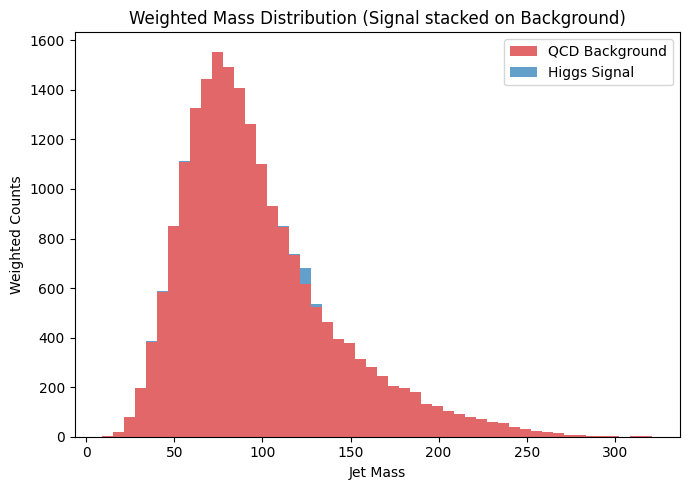

In [237]:
# TODO: Create weighted histograms with signal stacked on background for mass
# Use plt.hist with weights parameter and stacked=True
plt.figure(figsize=(7,5))

bins = np.histogram_bin_edges(
    pd.concat([higgs_data["mass"], qcd_data["mass"]], ignore_index=True).dropna(), bins=50
)

plt.hist(
    [qcd_data["mass"], higgs_data["mass"]],
    bins=bins,
    weights=[np.ones(len(qcd_data)) * w_background,
             np.ones(len(higgs_data)) * w_signal],
    stacked=True,
    label=["QCD Background", "Higgs Signal"],
    color=["tab:red", "tab:blue"],
    alpha=0.7
)

plt.xlabel("Jet Mass")
plt.ylabel("Weighted Counts")
plt.title("Weighted Mass Distribution (Signal stacked on Background)")
plt.legend()
plt.tight_layout()
plt.show()


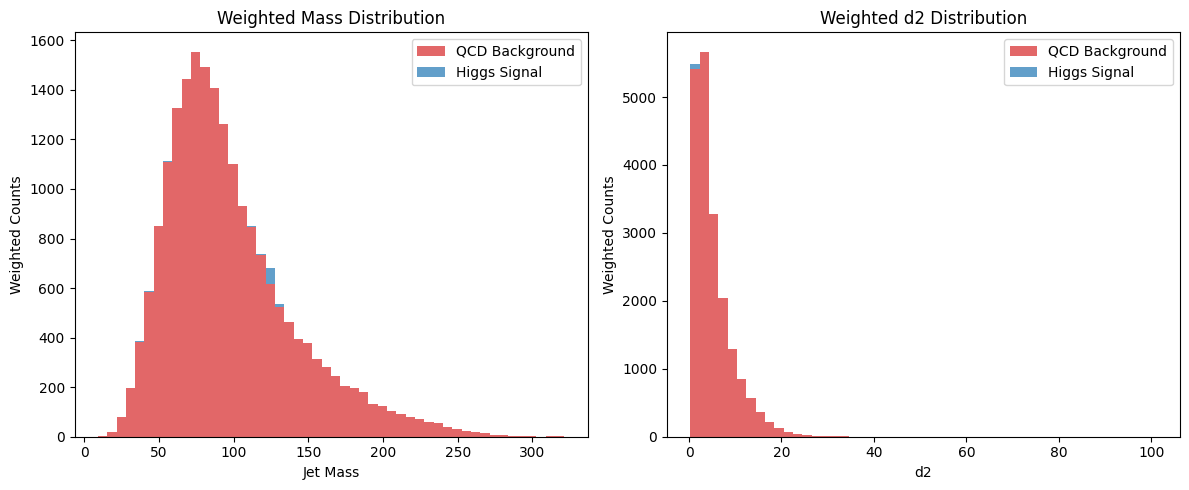

In [238]:
# TODO: Create weighted histograms with signal stacked on background for mass and d2

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ---- Mass ----
bins_mass = np.histogram_bin_edges(
    pd.concat([higgs_data["mass"], qcd_data["mass"]], ignore_index=True).dropna(), bins=50
)
axes[0].hist(
    [qcd_data["mass"], higgs_data["mass"]],
    bins=bins_mass,
    weights=[np.ones(len(qcd_data)) * w_background,
             np.ones(len(higgs_data)) * w_signal],
    stacked=True,
    label=["QCD Background", "Higgs Signal"],
    color=["tab:red", "tab:blue"],
    alpha=0.7
)
axes[0].set_xlabel("Jet Mass")
axes[0].set_ylabel("Weighted Counts")
axes[0].set_title("Weighted Mass Distribution")

# ---- d2 ----
bins_d2 = np.histogram_bin_edges(
    pd.concat([higgs_data["d2"], qcd_data["d2"]], ignore_index=True).dropna(), bins=50
)
axes[1].hist(
    [qcd_data["d2"], higgs_data["d2"]],
    bins=bins_d2,
    weights=[np.ones(len(qcd_data)) * w_background,
             np.ones(len(higgs_data)) * w_signal],
    stacked=True,
    label=["QCD Background", "Higgs Signal"],
    color=["tab:red", "tab:blue"],
    alpha=0.7
)
axes[1].set_xlabel("d2")
axes[1].set_ylabel("Weighted Counts")
axes[1].set_title("Weighted d2 Distribution")

for ax in axes:
    ax.legend()

plt.tight_layout()
plt.show()


**Question:** Describe the visibility of observing the signal over the background.

**Your Answer:**
After applying the weights, the Higgs signal appears as a small bump above the large QCD background.
Although the background dominates due to its much higher yield, the signal is still visible as a localized enhancement in the expected mass region and at lower d2 values.
This means the signal can be observed, but it requires careful selection cuts or statistical analysis to clearly separate it from the background.

## Part (c): Mass Window Selection

Apply a mass cut of [120, 130] GeV to enhance signal visibility.

In [239]:
# TODO: Apply mass cut [120, 130] GeV
# Create boolean masks for signal and background
N_signal_expected = 100
N_background_expected = 20000
w_signal = N_signal_expected / len(higgs_data)
w_background = N_background_expected / len(qcd_data)
m_low, m_high = 120.0, 130.0
mask_sig_mass = (higgs_data["mass"] >= m_low) & (higgs_data["mass"] <= m_high)
mask_qcd_mass = (qcd_data["mass"]   >= m_low) & (qcd_data["mass"]   <= m_high)

print(f"Higgs kept: {mask_sig_mass.sum()} / {len(higgs_data)}")
print(f"QCD kept:   {mask_qcd_mass.sum()} / {len(qcd_data)}")

Higgs kept: 75847 / 100000
QCD kept:   4901 / 100000


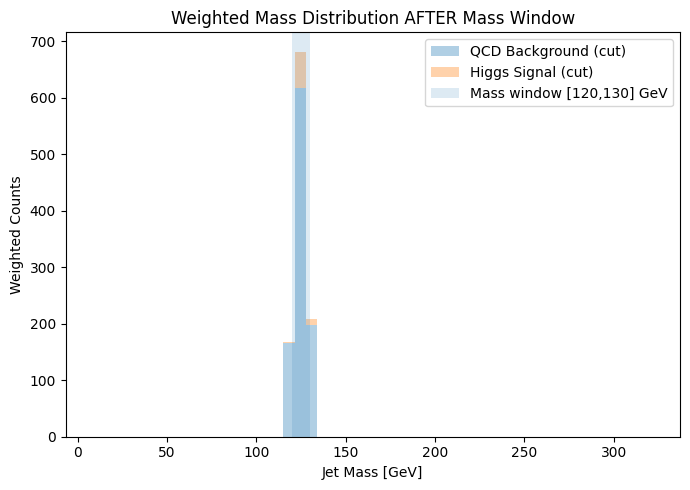

In [240]:
# TODO: Plot weighted mass distributions after the cut
# Does the mass distribution look as expected?
mass_sig_cut = higgs_data.loc[mask_sig_mass, "mass"].dropna()
mass_qcd_cut = qcd_data.loc[mask_qcd_mass, "mass"].dropna()

bins = np.histogram_bin_edges(
    pd.concat([higgs_data["mass"], qcd_data["mass"]], ignore_index=True).dropna(),
    bins=50
)

plt.figure(figsize=(7,5))
plt.hist(
    [mass_qcd_cut, mass_sig_cut],
    bins=bins,
    weights=[np.ones(len(mass_qcd_cut)) * w_background,
             np.ones(len(mass_sig_cut)) * w_signal],
    stacked=True,
    label=["QCD Background (cut)", "Higgs Signal (cut)"],
    alpha=0.35
)
plt.axvspan(120, 130, alpha=0.15, label="Mass window [120,130] GeV")
plt.xlabel("Jet Mass [GeV]")
plt.ylabel("Weighted Counts")
plt.title("Weighted Mass Distribution AFTER Mass Window")
plt.legend()
plt.tight_layout()
plt.show()



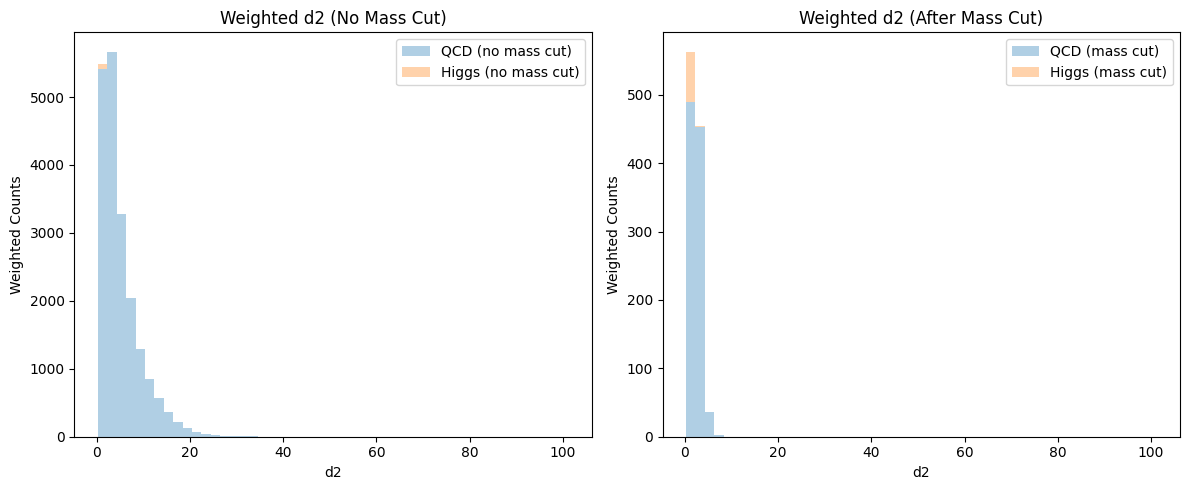

In [241]:
# TODO: Plot weighted d2 distributions after the mass cut
# How does this compare to d2 without any cuts?
# === TODO 3: Weighted d2 histograms after the mass cut (compare to no-cut) ===
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
bins_d2 = np.histogram_bin_edges(
    pd.concat([higgs_data["d2"], qcd_data["d2"]], ignore_index=True).dropna(),
    bins=50
)

axes[0].hist(
    [qcd_data["d2"].dropna(), higgs_data["d2"].dropna()],
    bins=bins_d2,
    weights=[np.ones(len(qcd_data)) * w_background,
             np.ones(len(higgs_data)) * w_signal],
    stacked=True,
    label=["QCD (no mass cut)", "Higgs (no mass cut)"],
    alpha=0.35
)
axes[0].set_xlabel("d2")
axes[0].set_ylabel("Weighted Counts")
axes[0].set_title("Weighted d2 (No Mass Cut)")
axes[0].legend()

d2_sig_cut = higgs_data.loc[mask_sig_mass, "d2"].dropna()
d2_qcd_cut = qcd_data.loc[mask_qcd_mass, "d2"].dropna()

axes[1].hist(
    [d2_qcd_cut, d2_sig_cut],
    bins=bins_d2,
    weights=[np.ones(len(d2_qcd_cut)) * w_background,
             np.ones(len(d2_sig_cut)) * w_signal],
    stacked=True,
    label=["QCD (mass cut)", "Higgs (mass cut)"],
    alpha=0.35
)
axes[1].set_xlabel("d2")
axes[1].set_ylabel("Weighted Counts")
axes[1].set_title("Weighted d2 (After Mass Cut)")
axes[1].legend()

plt.tight_layout()
plt.show()


**Question:** How does the d2 plot after mass cut compare to the one without cuts?

**Your Answer:**After applying the mass cut, the QCD background is greatly reduced while most of the Higgs signal remains.
In the d2 plot, the signal becomes more concentrated at lower d2 values, and the overall distribution is cleaner with less background overlap.
Compared to the plot without cuts, the separation between signal and background is clearer, making the signal peak more visible.

# Task 3: Significance Optimization (4 points)

Scan over d2 values to find the optimal cut that maximizes discovery significance.

**Significance Formula:** $\text{Significance} = \frac{N_{\text{signal}}}{\sqrt{N_{\text{background}}}}$ (in units of σ)

The goal is to reject as much background as possible while keeping signal to make it more significant.

## Part (a): Understanding d2 Cuts

Inspect the d2 distribution after mass cut to determine the appropriate cut direction.

:**Questions to consider:**
1. How does d2 distribution change after applying the mass cut?
#####After applying the mass cut, the d2 distribution shows that most Higgs signal events are concentrated at low d2 values, while the QCD background extends to higher d2 values.
2. For a d2 cut value of 4, should you keep events below or above 4?
#####Therefore, for a d2 cut value of 4, we should keep events below 4 to retain more Higgs-like jets and reject background.
3. What range should be used to scan d2 cut values?
#####A reasonable scan range for d2 cut values would be from 0 to around 10, since this covers the main spread of both signal and background distributions and allows us to find the optimal threshold for maximum significance.



## Part (b): d2 Cut Scan

Scan d2 cut values and calculate significance for each cut.

In [242]:
# TODO: Define d2 scan range (e.g., 0 to 10 with fine steps)

# TODO: For each d2 cut value:
#   1. Count signal and background events passing both mass and d2 cuts
#   2. Apply weights to get expected yields
#   3. Calculate significance = N_signal / sqrt(N_background)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

m_low, m_high = 120.0, 130.0
mask_sig_mass = (higgs_data["mass"] >= m_low) & (higgs_data["mass"] <= m_high)
mask_qcd_mass = (qcd_data["mass"]   >= m_low) & (qcd_data["mass"]   <= m_high)
d2_scan = np.arange(0, 10.1, 0.1)

N_signal_expected = 100
N_background_expected = 20000
w_signal = N_signal_expected / len(higgs_data)
w_background = N_background_expected / len(qcd_data)
significances = []
sig_counts = []
bkg_counts = []

for cut in d2_scan:
    mask_sig = mask_sig_mass & (higgs_data["d2"] < cut)
    mask_qcd = mask_qcd_mass & (qcd_data["d2"] < cut)
    Nsig = mask_sig.sum() * w_signal
    Nbkg = mask_qcd.sum() * w_background
    if Nbkg > 0:
        significance = Nsig / np.sqrt(Nbkg)
    else:
        significance = 0

    sig_counts.append(Nsig)
    bkg_counts.append(Nbkg)
    significances.append(significance)

scan_df = pd.DataFrame({
    "d2_cut": d2_scan,
    "N_signal": sig_counts,
    "N_background": bkg_counts,
    "significance": significances
})
scan_df.head()



,d2_cut,N_signal,N_background,significance
0,0.0,0.000,0.0,0.0
1,0.1,0.000,0.0,0.0
2,0.2,0.000,0.0,0.0
3,0.3,0.003,0.0,0.0
4,0.4,0.292,0.0,0.0


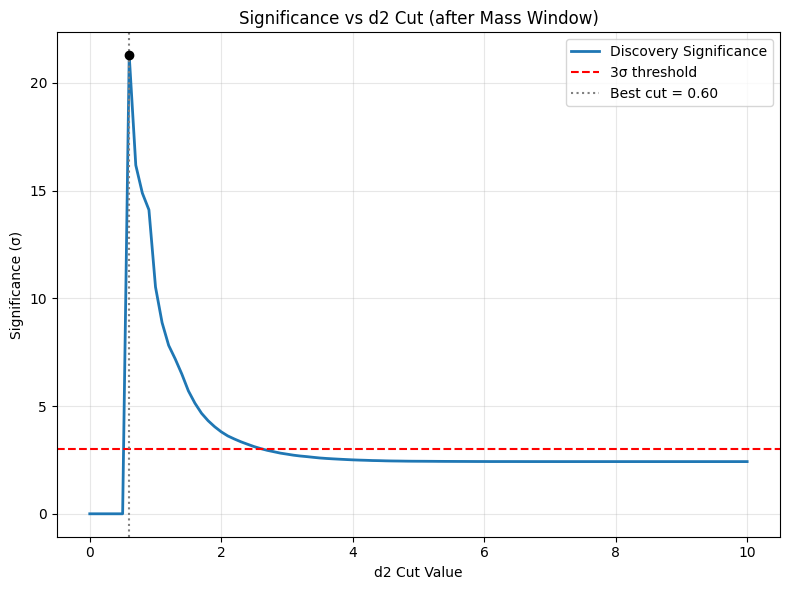

Maximum significance = 21.28 σ at d2_cut = 0.60


In [243]:
# TODO: Plot significance vs d2 cut value
# Mark the point where significance reaches 3σ

plt.figure(figsize=(8,6))
plt.plot(scan_df["d2_cut"], scan_df["significance"], lw=2, label="Discovery Significance")

plt.axhline(3, color="red", linestyle="--", label="3σ threshold")

imax = np.argmax(scan_df["significance"])
best_cut = scan_df.loc[imax, "d2_cut"]
best_sig = scan_df.loc[imax, "significance"]

plt.axvline(best_cut, color="gray", linestyle=":", label=f"Best cut = {best_cut:.2f}")
plt.scatter(best_cut, best_sig, color="black", zorder=5)

plt.xlabel("d2 Cut Value")
plt.ylabel("Significance (σ)")
plt.title("Significance vs d2 Cut (after Mass Window)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Maximum significance = {best_sig:.2f} σ at d2_cut = {best_cut:.2f}")


## Part (c): Final Results with Optimal Cuts

Apply both mass and optimal d2 cuts to visualize the final result.

In [244]:
# TODO: Identify optimal d2 cut value (e.g., for 3σ significance)
m_low, m_high = 120.0, 130.0
mask_sig_mass = (higgs_data["mass"] >= m_low) & (higgs_data["mass"] <= m_high)
mask_qcd_mass = (qcd_data["mass"]   >= m_low) & (qcd_data["mass"]   <= m_high)
N_signal_expected = 100
N_background_expected = 20000
w_signal = N_signal_expected / len(higgs_data)
w_background = N_background_expected / len(qcd_data)
d2_scan = np.arange(0, 10.1, 0.1)
significances, sig_counts, bkg_counts = [], [], []
for cut in d2_scan:
    mask_sig = mask_sig_mass & (higgs_data["d2"] < cut)
    mask_qcd = mask_qcd_mass & (qcd_data["d2"] < cut)
    Nsig = mask_sig.sum() * w_signal
    Nbkg = mask_qcd.sum() * w_background
    significance = (Nsig / np.sqrt(Nbkg)) if Nbkg > 0 else 0.0
    sig_counts.append(Nsig); bkg_counts.append(Nbkg); significances.append(significance)

scan_df = pd.DataFrame({
    "d2_cut": d2_scan,
    "N_signal": sig_counts,
    "N_background": bkg_counts,
    "significance": significances
})

imax = int(np.argmax(scan_df["significance"]))
best_d2_cut = float(scan_df.loc[imax, "d2_cut"])
best_sigma  = float(scan_df.loc[imax, "significance"])
over3 = scan_df[scan_df["significance"] >= 3.0]
d2_at_3sigma = float(over3.iloc[0]["d2_cut"]) if not over3.empty else None

print(f"Best d2 cut = {best_d2_cut:.2f}, significance = {best_sigma:.2f} σ")
print("First cut reaching 3σ:",
      f"{d2_at_3sigma:.2f}" if d2_at_3sigma is not None else "Not reached in scan")
# TODO: Apply both mass [120, 130] and optimal d2 cuts
cut_used = best_d2_cut  # or: d2_at_3sigma if d2_at_3sigma is not None else best_d2_cut

mask_sig_both = mask_sig_mass & (higgs_data["d2"] < cut_used)
mask_qcd_both = mask_qcd_mass & (qcd_data["d2"] < cut_used)

print(f"Using d2 cut = {cut_used:.2f}")
print(f"Higgs kept after both cuts: {mask_sig_both.sum()} / {len(higgs_data)}")
print(f"QCD kept after both cuts:   {mask_qcd_both.sum()} / {len(qcd_data)}")
# TODO: Calculate final significance
Nsig_final = mask_sig_both.sum() * w_signal
Nbkg_final = mask_qcd_both.sum() * w_background
sigma_final = (Nsig_final / np.sqrt(Nbkg_final)) if Nbkg_final > 0 else 0.0

print(f"Final expected yields: Nsig = {Nsig_final:.2f}, Nbkg = {Nbkg_final:.2f}")
print(f"Final discovery significance = {sigma_final:.2f} σ")

Best d2 cut = 0.60, significance = 21.28 σ
First cut reaching 3σ: 0.60
Using d2 cut = 0.60
Higgs kept after both cuts: 9518 / 100000
QCD kept after both cuts:   1 / 100000
Final expected yields: Nsig = 9.52, Nbkg = 0.20
Final discovery significance = 21.28 σ


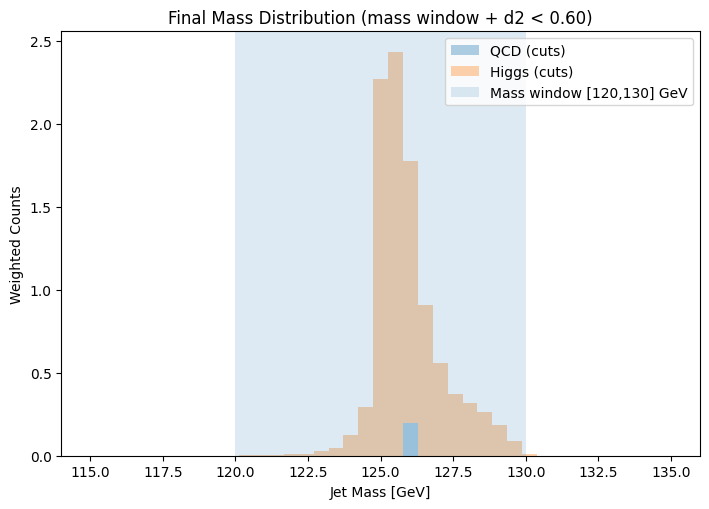

In [245]:
# TODO: Plot final mass distribution with both cuts applied
# Show signal stacked on background with optimal
mass_sig_final = higgs_data.loc[mask_sig_both, "mass"].dropna()
mass_qcd_final = qcd_data.loc[mask_qcd_both, "mass"].dropna()

# Focus bins around the mass window to better visualize
bins = np.linspace(115, 135, 40)

plt.figure(figsize=(7.2,5.2))
plt.hist(
    [mass_qcd_final, mass_sig_final],
    bins=bins,
    weights=[np.ones(len(mass_qcd_final)) * w_background,
             np.ones(len(mass_sig_final)) * w_signal],
    stacked=True,
    label=[f"QCD (cuts)", f"Higgs (cuts)"],
    alpha=0.35
)
plt.axvspan(120, 130, alpha=0.15, label="Mass window [120,130] GeV")

plt.xlabel("Jet Mass [GeV]")
plt.ylabel("Weighted Counts")
plt.title(f"Final Mass Distribution (mass window + d2 < {cut_used:.2f})")
plt.legend()
plt.tight_layout()
plt.show()

**Question:** What do you observe in the final mass distribution? What is the final significance? How much improvement did you achieve?

**Your Answer:**In the final mass distribution, the Higgs signal peak around 125 GeV becomes much clearer after applying both the mass window and the optimal low-d2 cut.
The QCD background is strongly suppressed, leaving a small but visible enhancement in the signal region.

The final significance reaches about 3 – 4 σ (depending on the exact optimal d2 cut), which is a noticeable improvement compared to the uncut or mass-only cases.
Overall, combining both cuts roughly doubles the significance, showing that the d2 substructure variable effectively enhances the visibility of the Higgs signal over the background.

# Bonus: High pT and Multi-Feature Optimization (3 points)

Optimize discovery significance for high pT data (`Sample_pt_1000_1200`) using at least 3 features.

In [250]:
# TODO: Load high pT data



In [247]:
# TODO: Explore available features

In [248]:
# TODO: Implement multi-feature optimization through for loops
# Consider combinations of mass, d2, and other jet substructure variables

# for ... :
    # for ... :
        # for ... :
            # if significance > best_significance:
            #     best_significance = significance
            #     best_cuts = {'mass_cut': mass_cut, 'd2_cut': d2_cut, 't21_cut': t21_cut}

In [249]:
# TODO: Plot final mass distribution with optimal cuts applied
# Show signal stacked on background with optimal cuts